# Machine Learning 1

### **Table of Contents**




## Introduction

The objective of this analysis is to examine whether a country’s dominant political ideology – categorized as left, center, or right – can be predicted from its economic indicators. We also explore how economic metrics (e.g. growth, trade, military spending) correlate with shifts in political ideology or election outcomes, and whether countries cluster into profiles with similar economic-political characteristics. Rickardsson,2021 suggests that there is a divide between urban and rural populations for voting characteristics. Possibly because of lower access to public services in rural areas, they respond to the deterioration of their location by casting a vote on the far-right. Economic voting phenomena suggests that, voters hold the major incumbent party accountable for recent economic performance while voting. In addition, recent research shows that higher levels of GDP in a country result in greater far-right preference (Lucassen &  Lubbers ,2011). In authoritarian regimes, military spending tends to be higher than in democratic regimes while right-wing governments spend more on arms purchases and left-wing governments spend more on military personnel (Carter,2016). In the light of these findings, we wanted to explore the relationship between leader ideologies, economic indicators, military spending and urban population counts using predictive modeling.

The project involves assembling data from multiple sources, conducting thorough exploratory data analysis (EDA), building predictive models, and interpreting key drivers, all compiled into a client-ready report. Below, we present the process and findings in a structured manner.

Our research questions are the following :

**Are economic indicators related to selected leader ideologies?**

**Can we predict military spending from leader ideologies and other economic indicators?**

**Is there a relationship between urban population counts with leader ideologies and other economic indicators?**


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
import statsmodels.formula.api as smf




## 2. Data and Cleaning 
Data Sources: We worked with three datasets provided in ML1-HSLU-main.zip:
- **Global Economy Indicators** – Annual economic data for countries (e.g. GDP, GNI, sector outputs, trade). from 
- **Global Leader Ideologies** – Yearly classification of each country’s head-of-government ideology (left/center/right) from 1945–2020.
- **Military Spending** – Country-level military expenditure as % of GDP (World Bank indicator). from
- **Rural/Urban Population** - Unemployment (%) and population (count)  data from

#### Steps:
    1. **Extraction & Initial Inspection:** All files were extracted and loaded into data frames. The economy dataset contains 26 indicators for 200+ countries (years ~1970–2021), the ideology dataset classifies leaders for ~180 countries (1945–2020), and the military dataset provides %GDP spending for ~260 entities (1960–2023, including some regions). We identified that the economy data uses country names and IDs, the ideology data uses country names and Correlates-of-War codes, and the military data uses country names and ISO codes. Merging required a common country identifier and year.
    2. **Trimming & Encoding:** Removed extraneous whitespace and standardized text encoding for country names and other string fields. For example, country names like " Afghanistan " were stripped to "Afghanistan".
    3. **Country Name Alignment:** Matched country naming conventions across datasets. We created a mapping to resolve differences (e.g. "United States" in economy data was renamed to "United States of America" to match the ideology dataset; "Bolivia (Plurinational State of)" was simplified to "Bolivia"). We also merged historical entries to current names where appropriate (e.g. economy data had separate entries for "Yemen Arab Republic (Former)" and "Yemen Democratic (Former)", which we mapped to "Yemen" and "South Yemen" respectively to align with the ideology data).
    4. **Handling Missing Values:** The ideology dataset contained entries with “no information” or “missing ideology” for some early years – we exclude those from modeling since they aren’t left/center/right.
    5. **Wide to long format Conversions:**  Reshaped military from wide to long format.
    6. **Merging Data:** Using cleaned country names and year as keys, we merged the datasets into a unified dataframe. The final dataset for the analysis includes years 1990-2020, contains ~2897 observations, 266 countries with 25 columns for:

            *   Economic indicators (GDP (USD), GNI (USD), population, sector outputs (USD) ~ (agriculture, construction,transport,wholesale,mining) ; trade (USD) ~ (inventory changes,IMF exchange rate,imports, exports ,gross capital)),
    
            *   Military spending (% of GDP),
    
            *   Leader’s political ideology  ( right,left,center), democracy (true/false),government ideology (hog: right, left, center), match of hog and leader (true/false) and region

            *   Urban/Rural population counts
    

        We confirmed that key variables like GDP and GNI are in units (economy data indicated GNI in USD), rows with incomplete features and missing data were dropped for modeling to ensure algorithms receive complete cases.



## 3. Exploratory Data Analysis
With a clean, merged dataset, we performed EDA to understand the distributions of variables, relationships between economic indicators and ideology, and potential multicollinearity or clustering patterns.

**Summary Statistics:** We first examined summary stats for the key indicators. There is wide variability in country economic profiles – e.g. population ranges from microstates under 100k to countries over 1 billion; GDP ranges several orders of magnitude. Economic metrics are highly skewed (a few very large economies drive the upper ranges), which justifies our use of log transforms for analysis. The **ideology distribution** in the data is roughly: 49% leftist, 41% rightist, and 10% centrist (counting each country-year as one observation). This indicates centrist governments are comparatively rare in the dataset, a point to keep in mind for modeling (class imbalance). We also noted potential regional patterns: for example, many Western European and North American entries are coded as center or right, whereas a number of Latin American and African country-years are coded as left (often in the context of socialist or populist leaders in certain periods). These are general trends – we will explore if the data supports them.


In [2]:

data = pd.read_csv("new_data_with_count.csv")
data.dropna()
data.rename(columns={'Gross.National.Income.GNI..in.USD': 'gross_national_income_GNI', 'Military.expenditure....of.GDP.': 'military_expenditure','Gross.Domestic.Product..GDP.': 'GDP'}, inplace=True)
valid_ideologies = ["leftist", "rightist", "centrist"]

data= data[data["leader_ideology"].isin(valid_ideologies)]
data= data[data["hog_ideology"].isin(valid_ideologies)]
# Ensure democracy is binary (convert 'yes'/'no' to 1/0 if needed)
data.columns = data.columns.str.replace('.', '_', regex=False)


print(data.head())
data.dropna()


   Unnamed: 0  Country  Year hog_ideology leader_ideology match_hog_leader  \
0           1  Albania  1990      leftist         leftist              yes   
1           2  Albania  1996     rightist        rightist               no   
2           3  Albania  1997      leftist         leftist              yes   
3           4  Albania  1998      leftist         leftist              yes   
4           5  Albania  1999      leftist         leftist              yes   

  democracy                           region  IMF_based_exchange_rate  \
0        no  Eastern Europe and Central Asia                 7.745833   
1        no  Eastern Europe and Central Asia               104.498917   
2        no  Eastern Europe and Central Asia               148.932917   
3        no  Eastern Europe and Central Asia               150.633333   
4        no  Eastern Europe and Central Asia               137.690583   

   Population  ... Gross_capital_formation  Imports_of_goods_and_services  \
0   3295066.0  

,Unnamed: 0,Country,Year,hog_ideology,leader_ideology,match_hog_leader,democracy,region,IMF_based_exchange_rate,Population,...,Gross_capital_formation,Imports_of_goods_and_services,mining_manifacturing_isic,transport_storage_communication_isic,wholesale_trade_restaurant_hotel_isic,gross_national_income_GNI,GDP,military_expenditure,Urban_population,Rural_population
0,1,Albania,1990,leftist,leftist,yes,no,Eastern Europe and Central Asia,7.745833,3295066.0,...,5.431669e+08,4.828841e+08,8.631767e+08,2.985798e+07,1.391204e+08,2.143811e+09,2.145751e+09,5.888301,1197222.0,2089320.0
1,2,Albania,1996,rightist,rightist,no,no,Eastern Europe and Central Asia,104.498917,3271331.0,...,4.509509e+08,1.158532e+09,3.280966e+08,1.143496e+08,6.252993e+08,3.271327e+09,3.199642e+09,1.379030,1250518.0,1917515.0
2,3,Albania,1997,leftist,leftist,yes,no,Eastern Europe and Central Asia,148.932917,3253719.0,...,3.795503e+08,8.673393e+08,2.076360e+08,1.021116e+08,4.391012e+08,2.274234e+09,2.224654e+09,1.283081,1260414.0,1887867.0
3,4,Albania,1998,leftist,leftist,yes,no,Eastern Europe and Central Asia,150.633333,3232175.0,...,5.591266e+08,1.026883e+09,2.091365e+08,1.432659e+08,4.976294e+08,2.631658e+09,2.554869e+09,1.238243,1270214.0,1858316.0
4,5,Albania,1999,leftist,leftist,yes,no,Eastern Europe and Central Asia,137.690583,3208260.0,...,7.829524e+08,1.204031e+09,2.561817e+08,1.987122e+08,6.829865e+08,3.297165e+09,3.221670e+09,1.249210,1279853.0,1828925.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2950,Zimbabwe,2016,leftist,leftist,yes,no,Sub-Saharan Africa,1.000000,14452704.0,...,2.026381e+09,6.426700e+09,4.102626e+09,2.091819e+09,4.128620e+09,1.877295e+10,2.054868e+10,1.741985,4715311.0,9884983.0
2950,2951,Zimbabwe,2017,leftist,leftist,yes,no,Sub-Saharan Africa,1.000000,14751101.0,...,3.240458e+09,6.693807e+09,6.637330e+09,2.250543e+09,4.421973e+09,2.118140e+10,2.204065e+10,1.592340,4775100.0,10037382.0
2951,2952,Zimbabwe,2018,leftist,leftist,yes,no,Sub-Saharan Africa,1.000000,15052184.0,...,3.345405e+09,6.712015e+09,6.870555e+09,2.492558e+09,4.772648e+09,2.315156e+10,2.364527e+10,1.137810,4842447.0,10192005.0
2952,2953,Zimbabwe,2019,leftist,leftist,yes,no,Sub-Saharan Africa,1.000000,15354608.0,...,3.117897e+09,5.767050e+09,6.623454e+09,1.680270e+09,5.008252e+09,2.223810e+10,2.259452e+10,0.729567,4918908.0,10352460.0


In [3]:
print(data.describe())



        Unnamed: 0         Year  IMF_based_exchange_rate    Population  \
count  2910.000000  2910.000000             2.910000e+03  2.910000e+03   
mean   1476.279381  2005.403780             3.590835e+02  4.874920e+07   
std     856.492919     8.782866             1.277384e+03  1.615665e+08   
min       1.000000  1990.000000             2.990000e-08  3.653920e+05   
25%     731.250000  1998.000000             1.000000e+00  4.519950e+06   
50%    1474.500000  2005.500000             6.459693e+00  1.046894e+07   
75%    2219.750000  2013.000000             1.014537e+02  2.953516e+07   
max    2954.000000  2020.000000             1.458220e+04  1.424930e+09   

       Per_capita_GNI  agriculture_and_hunting_fishing_isic  \
count     2910.000000                          2.910000e+03   
mean     11779.468385                          1.677482e+10   
std      16642.161340                          6.740845e+10   
min         93.000000                          1.291251e+07   
25%       1129.500

We see that min year is 1990 and max is 2020 so this confirms our filter. Mean military expenditure is aroung 2 percent of GDP, In the dataset urban and rural population counts seem to be balanced. Mean GDP is 4753213e+11. Compared to other sectors, wholesale seems to be the one with the highest USD output. SD is high in construction outputs.

Visualizing correlations helps us see how variables relate:

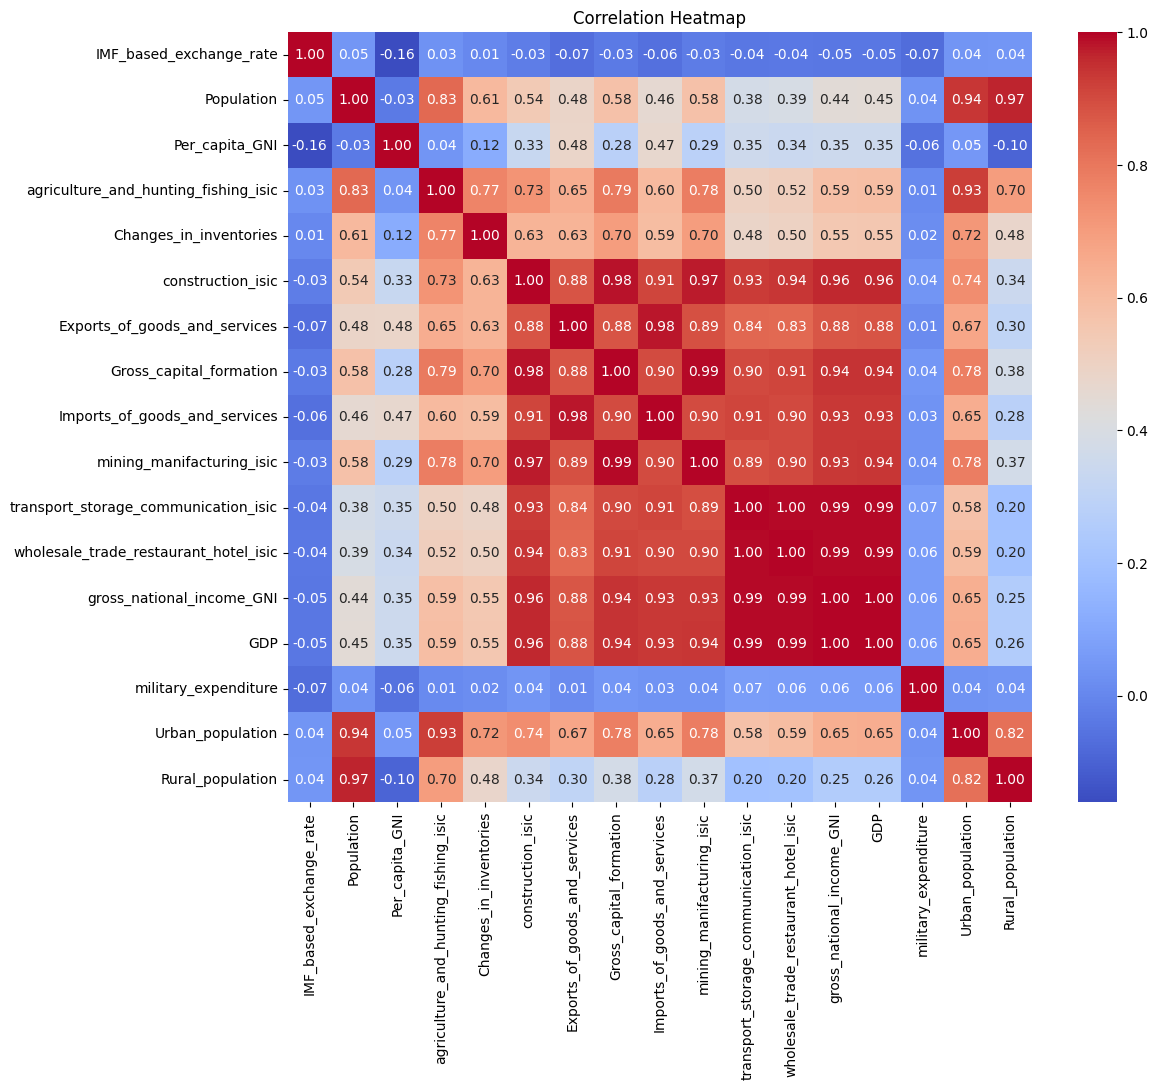

In [4]:
selected_cols = ['IMF_based_exchange_rate', 'Population', 'Currency', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']



plt.figure(figsize=(12,10))
sns.heatmap(data[selected_cols].corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


It seems like we have strong correlation for various variables. Military expenditure and exchange rates seem to be not correlated to other variables. Changes in inventories,population(we are interested in urban only), export-import( one to be chosen),gross capital formation,wholesale(tranport has 1 correlation), gdp or gni to be left or chosen.

We need to define target and features because it is hard to see how variables relate

In [5]:
features = ['IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']

X = data[features]
y = data['leader_ideology']

We want to see a Distribution plots for numerical variables

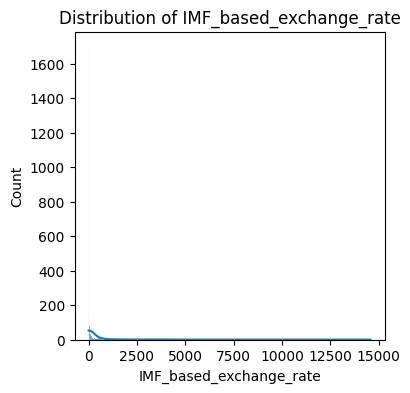

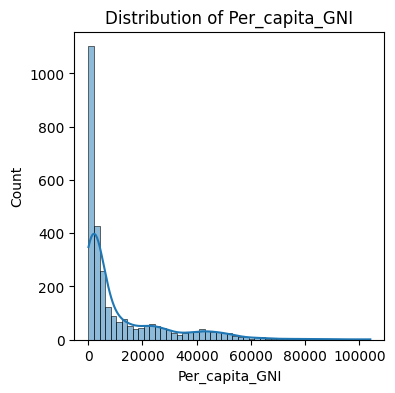

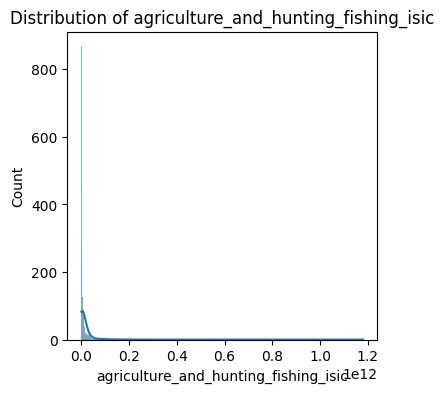

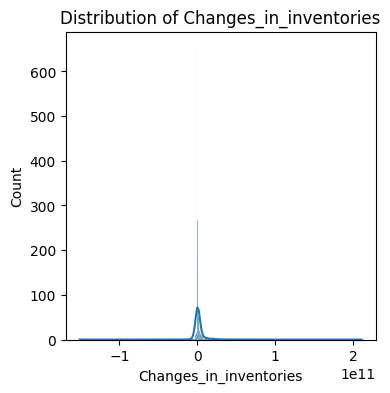

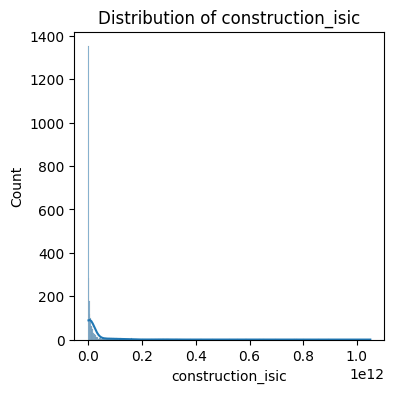

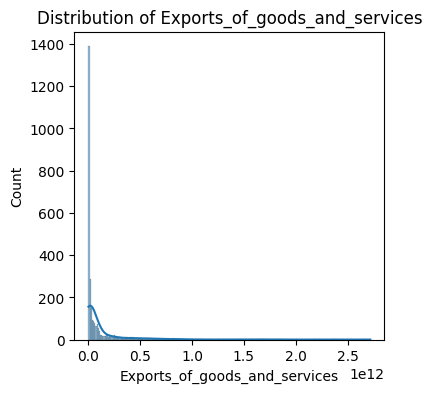

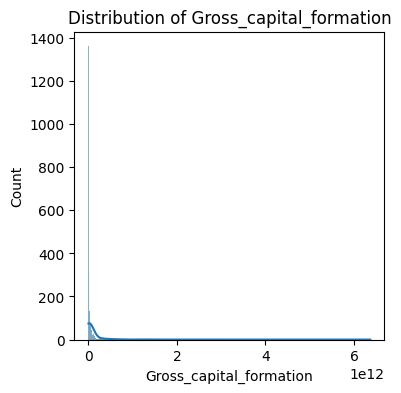

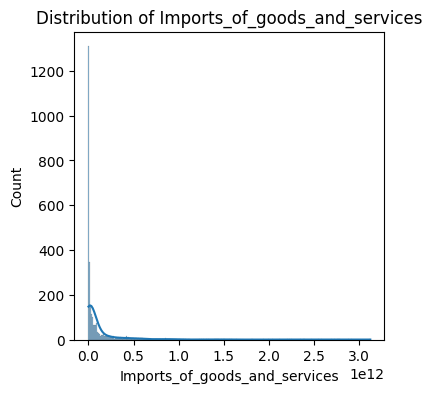

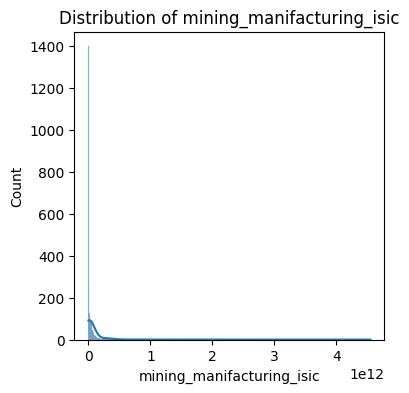

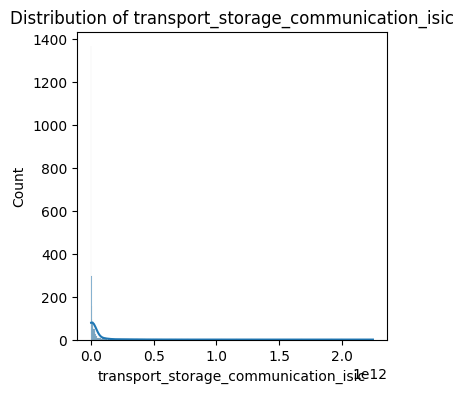

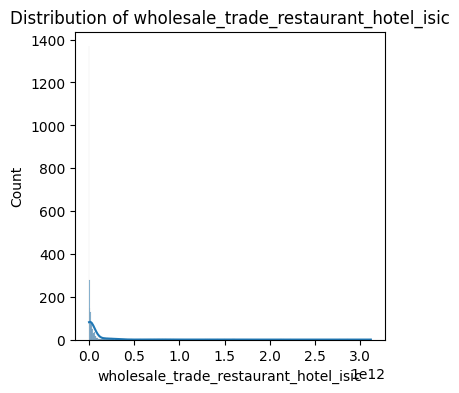

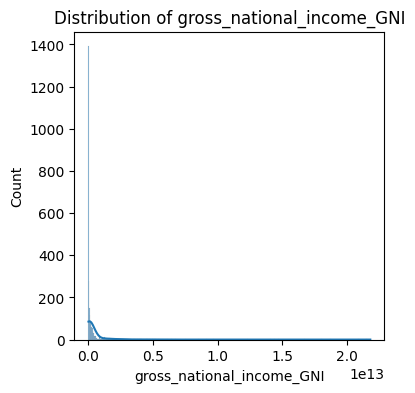

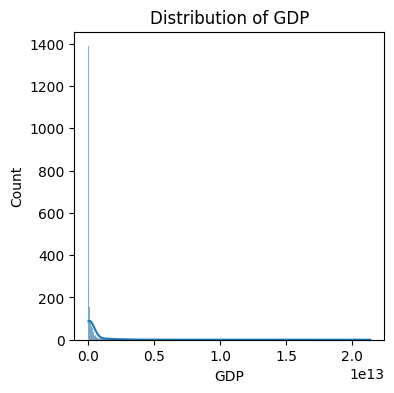

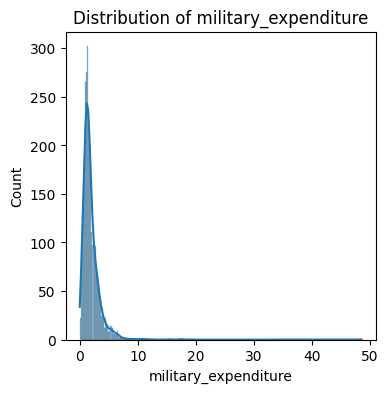

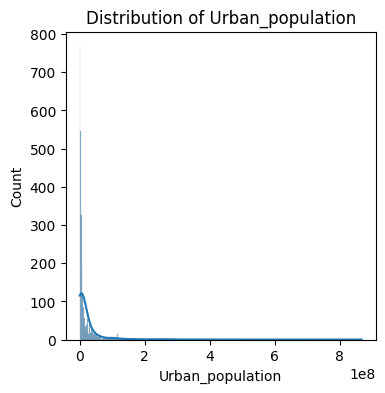

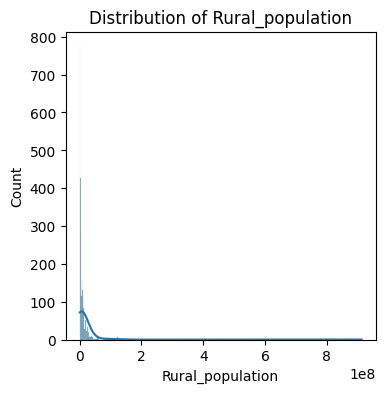

In [6]:
for feature in features:
    plt.figure(figsize=(4,4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

Except changes in inventories, all the variables seems to be right skewed. So we do log transformations to normalize the distribution.

In [7]:

selected_cols = ['IMF_based_exchange_rate','Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']

# Apply log transform
df_log = data.copy()

df_log[selected_cols] = np.log1p(df_log[selected_cols])  # or np.log1p() if values may be zero


c:\Users\irmak\Desktop\datascience\lulzern\.conda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


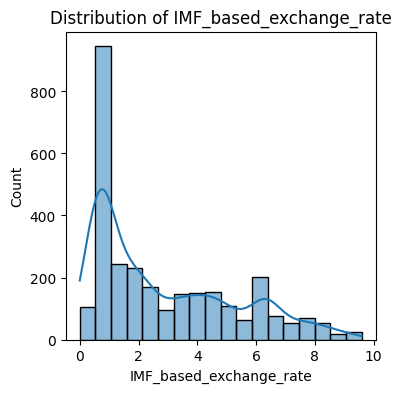

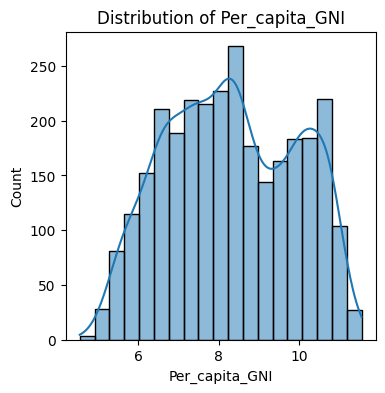

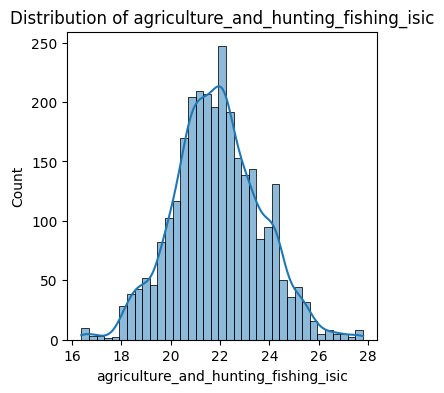

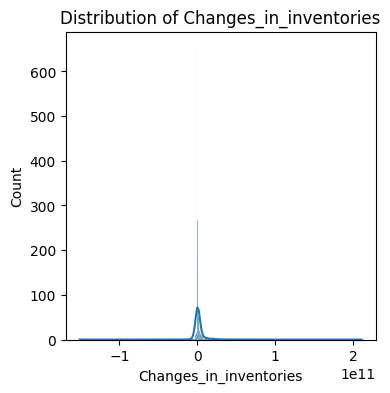

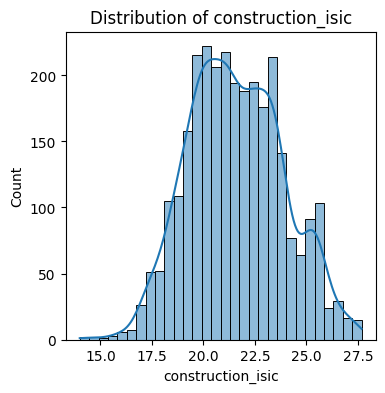

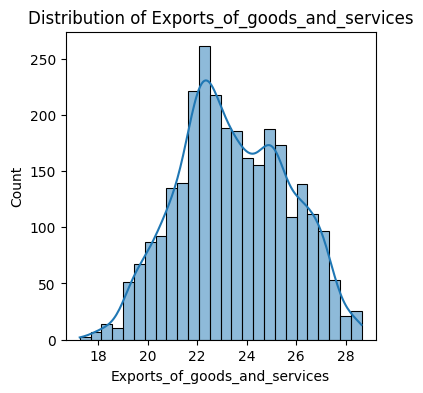

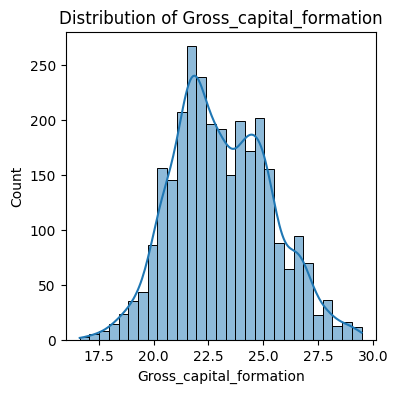

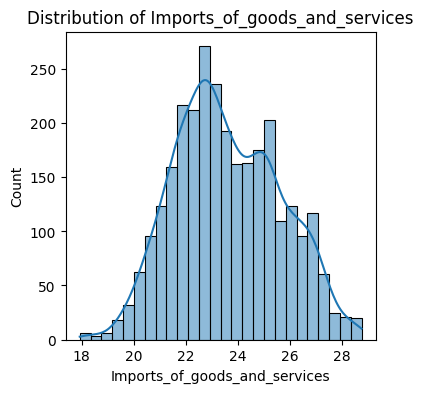

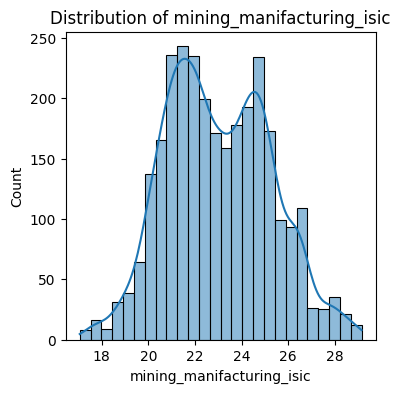

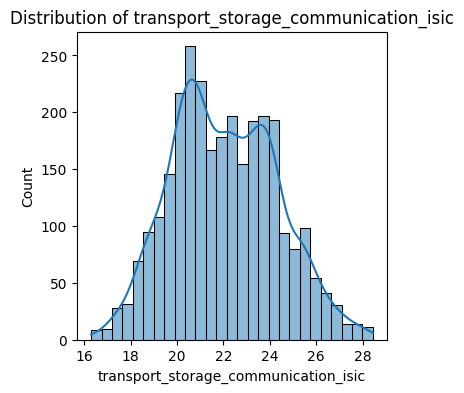

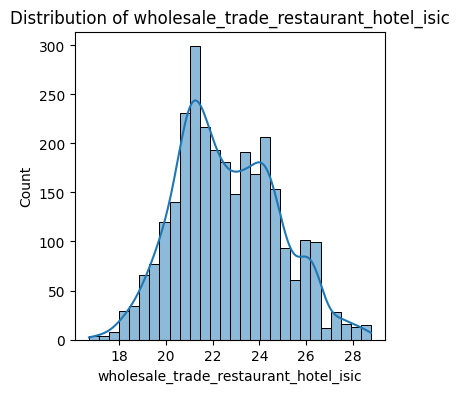

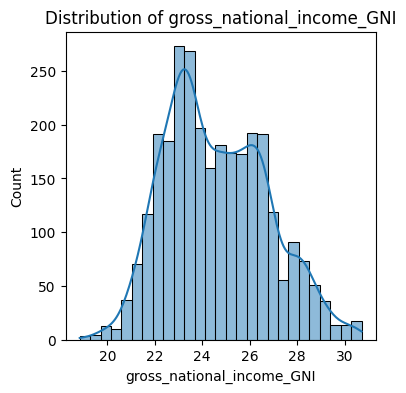

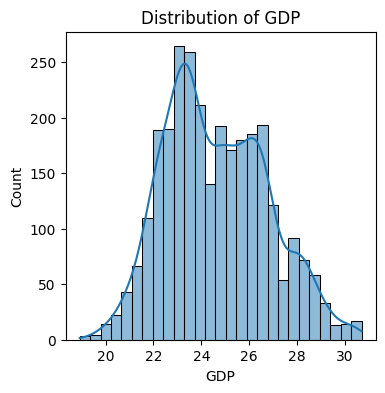

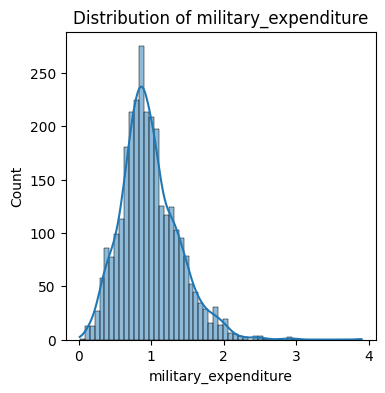

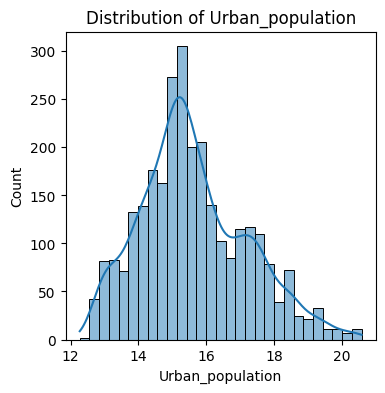

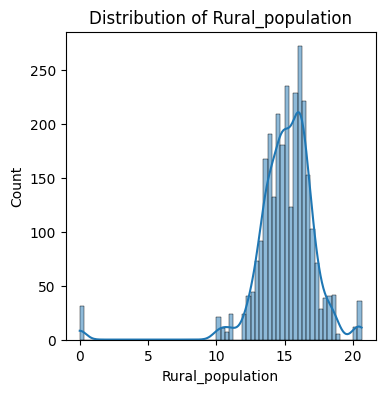

In [8]:
for feature in features:
    plt.figure(figsize=(4,4))
    sns.histplot(df_log[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

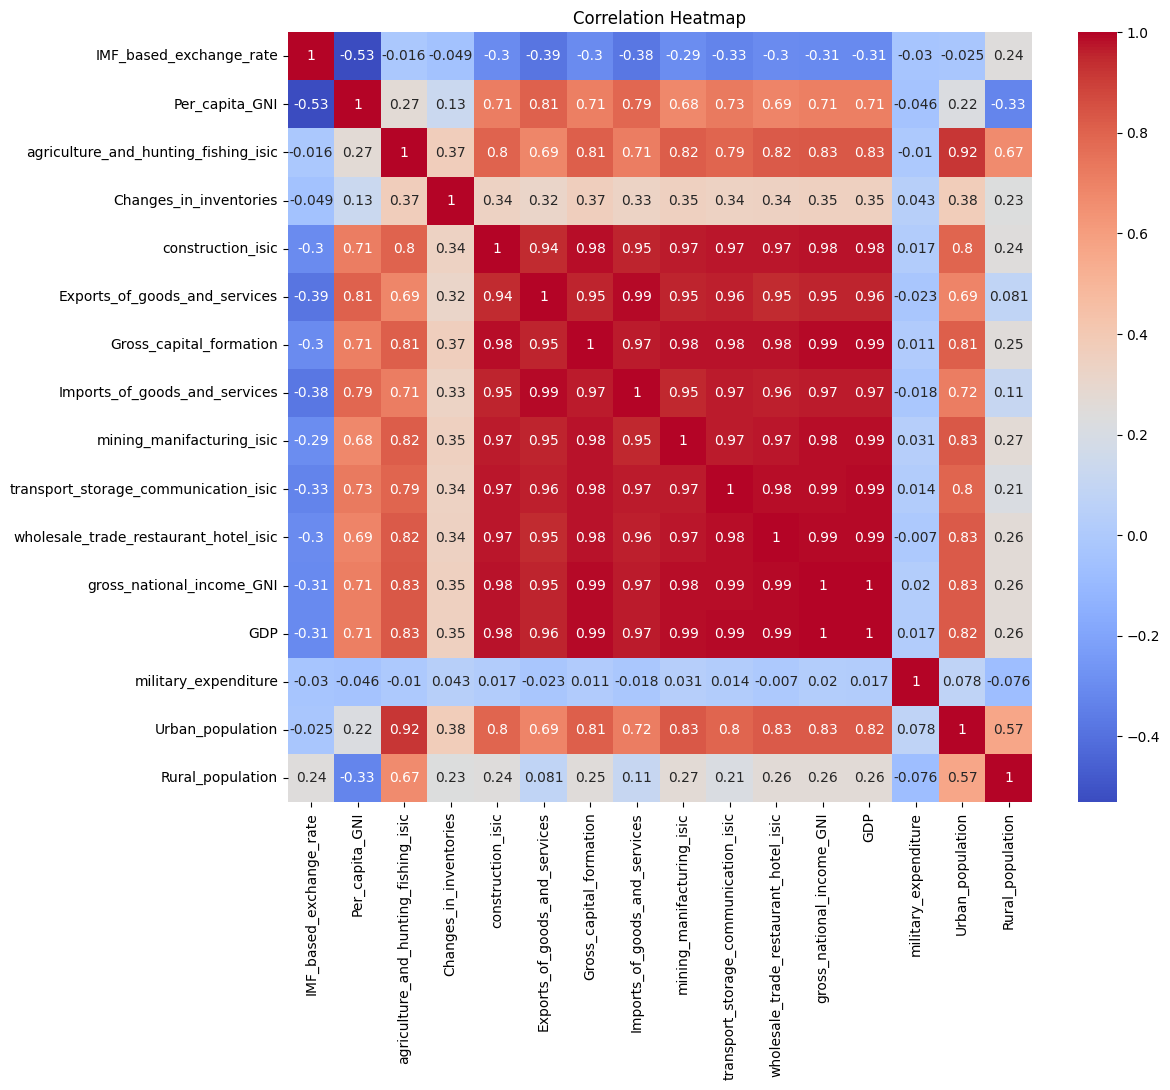

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(df_log[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

IMF, per capita GNI,GDP, /construction or agriculture,import or export
no gross capiral formation,IMF exchange  rate,change in inventories,wholesale,gross national income,rural pop .
VIF analysis here? PCA.
**Correlations Among Economic Indicators:** Many economic variables are naturally correlated. We visualized a correlation heatmap of the main indicators to identify multicollinearity:

_Correlation heatmap of key economic indicators._ As expected, we see strong correlations among related features. For instance, **Exports and Imports share** are positively correlated (countries open to trade tend to be high in both), and **GDP vs. population** shows correlation (larger populations often produce larger total GDP). Interestingly, **agricultural share (agri\_share)** is negatively correlated with per-capita GNI – economies with higher agriculture/GDP tend to have lower income levels, reflecting development status. **Government consumption share** has a mild negative correlation with GDP (richer economies sometimes have slightly lower gov’t spending % of GDP, though not a strict rule). **Military spending %GDP** is not strongly correlated with most economic size metrics, indicating that a nation’s defense burden varies idiosyncratically (e.g. some rich countries spend low % on military, some poorer or strategic countries spend high %). These correlations informed which variables to include or transform for modeling (to avoid redundancy). We decided to exclude some highly collinear features (for example, total GDP was dropped in favor of per-capita GNI and population, and we use share-of-GDP measures rather than absolute expenditures to normalize for economy size).


## Ideology distribution

Right and left wing leaders ideologies seems to be balanced, there is imbalance in centrists. The countries included in the dataset have two times more democracies than other regimes.

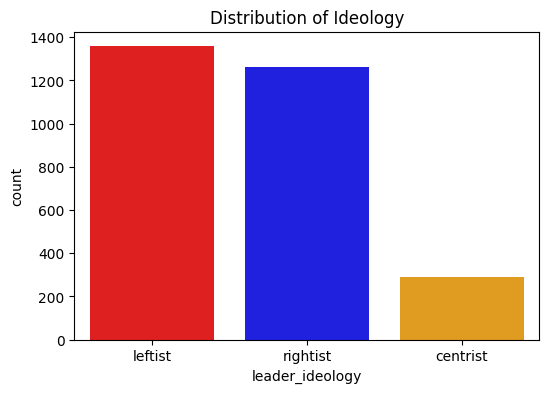

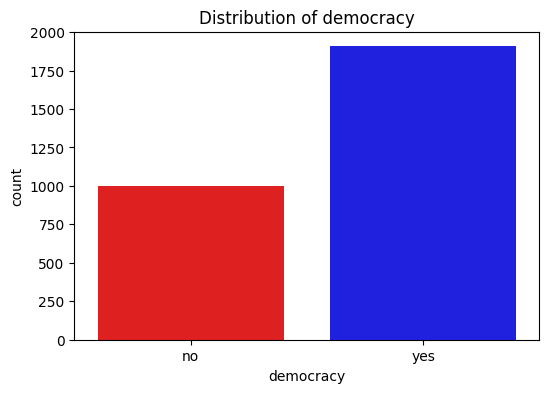

C:\Users\irmak\AppData\Local\Temp\ipykernel_9712\4255027667.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_log[col].dropna() for col in cols_to_plot], labels=cols_to_plot)


Text(0.5, 1.0, 'Box Plot of Rural and Urban populations')

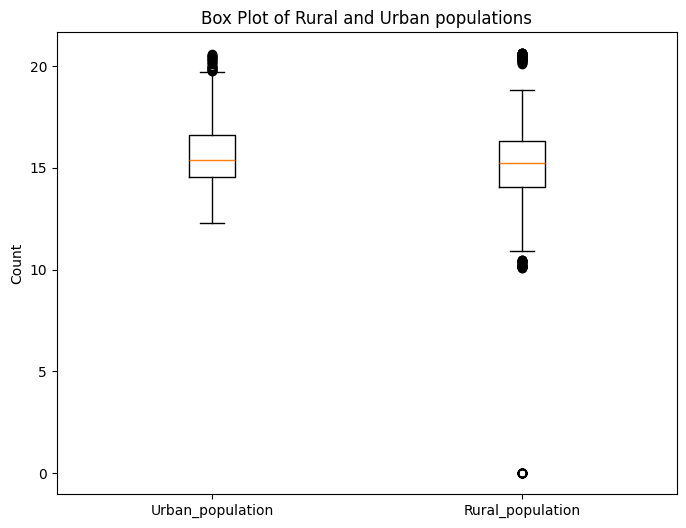

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_log, x='leader_ideology',
    hue='leader_ideology',
    dodge=False,
    palette=['red', 'blue', 'orange'],
    legend=False)
plt.title('Distribution of Ideology')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df_log, x='democracy',
    hue='democracy',
    dodge=False,
    palette=['red', 'blue'],
    legend=False)
plt.title('Distribution of democracy')
plt.show()

# Replace with your actual column names
cols_to_plot = ['Urban_population', 'Rural_population']

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([df_log[col].dropna() for col in cols_to_plot], labels=cols_to_plot)

# Add labels and title
plt.ylabel('Count')
plt.title('Box Plot of Rural and Urban populations')

**Profiles by Ideology:** Next, we explored how indicators differ by the ruling ideology. We segmented the data by ideology and compared distributions:

_Per-capita income (GNI per person) distribution by dominant ideology (log scale)._ We observe distinct income profiles: right-leaning governments are slightly more common in higher-income country-years, while left-leaning governments appear frequently in lower-income contexts (the median per-capita GNI for **rightist-led** observations is higher than for **leftist-led**). Centrist cases are often high-income democracies as well (e.g. some coalition governments in Europe), reflected by a relatively high median in the boxplot; however, the centrist category has broad spread due to fewer data points. This suggests a historical pattern where very wealthy countries rarely elect far-left leaders, whereas poorer countries may swing to leftist leadership (often promising redistribution) – though there are notable exceptions on both ends. It’s important to note these are **correlations, not causations**: the economic stage of a country and its political ideology influence each other in complex ways.

We also examined other indicators: Left-led governments tended to have **higher government consumption as % of GDP on average** (consistent with left ideology favoring a larger state role), whereas right-led governments showed slightly **lower gov’t share and higher military spending share**. For example, the average military expenditure was ~2.5% of GDP for right-wing led country-years vs. ~2.0% for left-wing led ones. Similarly, the data hints that leftist regimes occur more in agrarian economies, whereas rightist regimes often preside over more industrialized economies with lower agriculture dependence – again reflecting that many OECD countries tilt right or center, whereas revolutionary socialist governments occurred in developing nations.


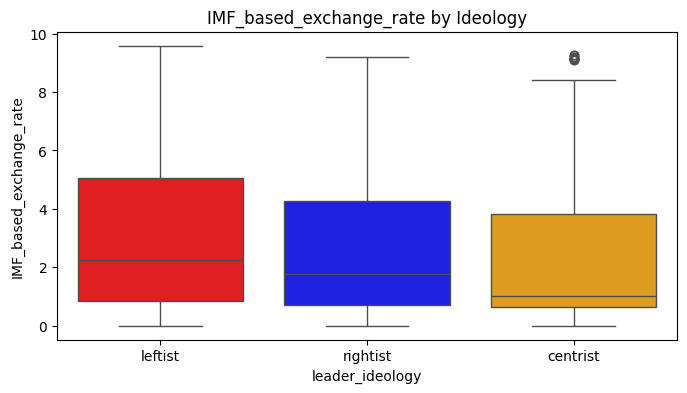

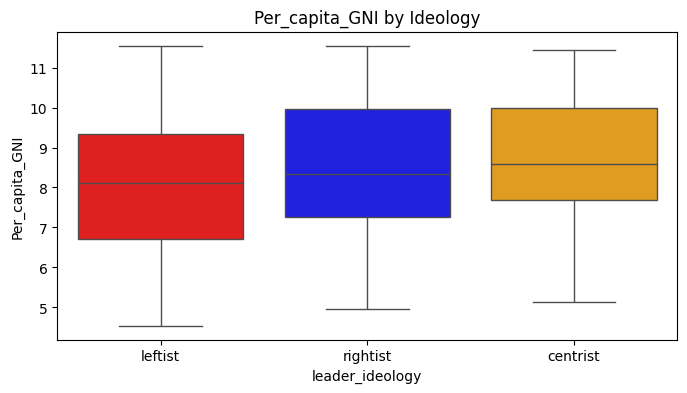

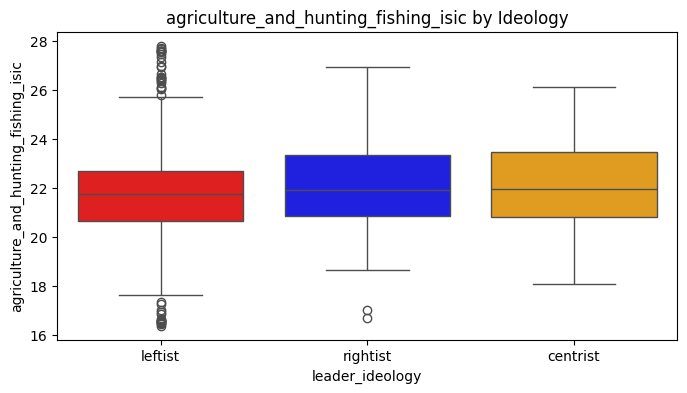

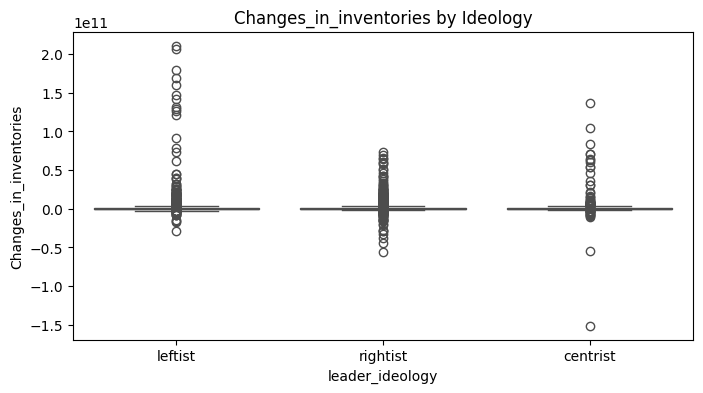

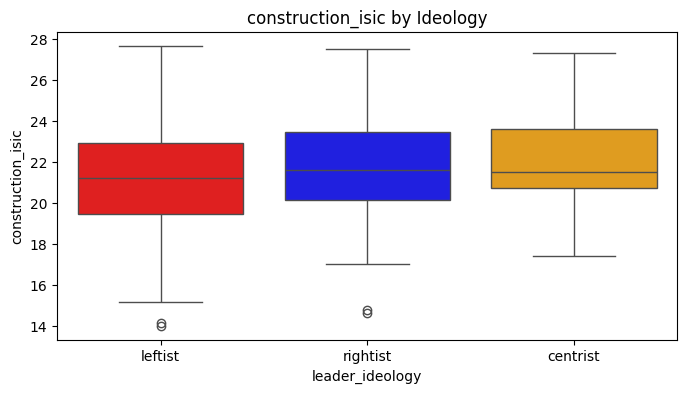

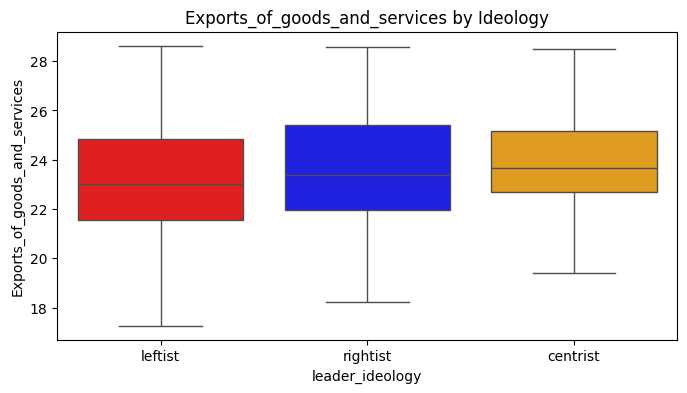

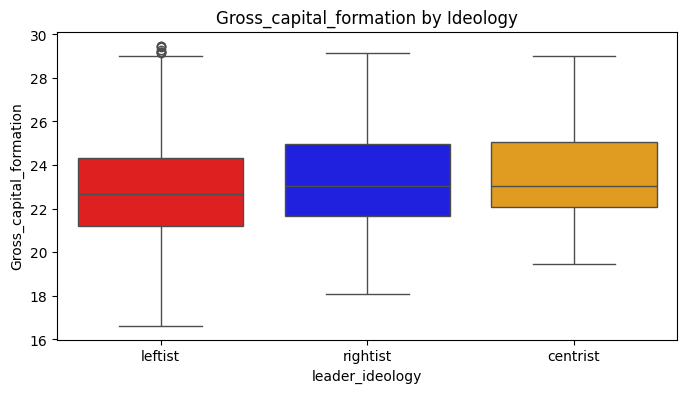

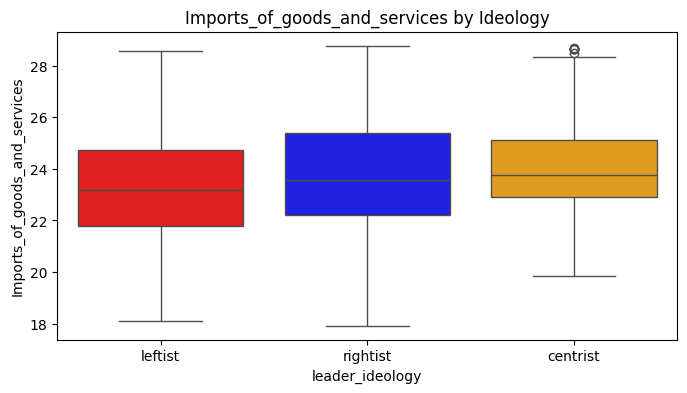

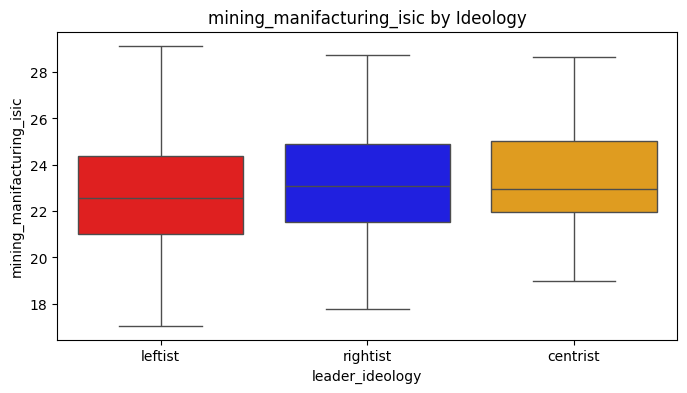

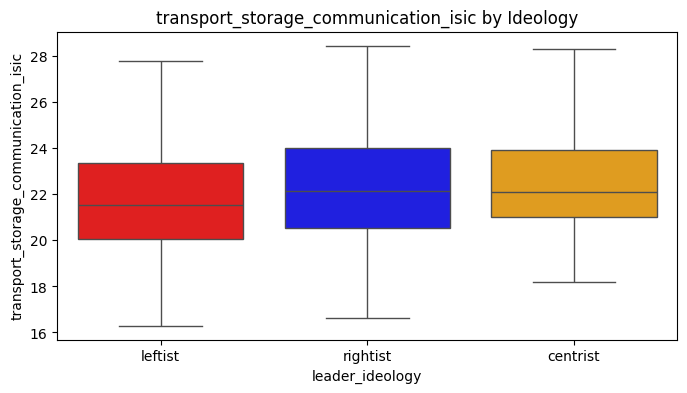

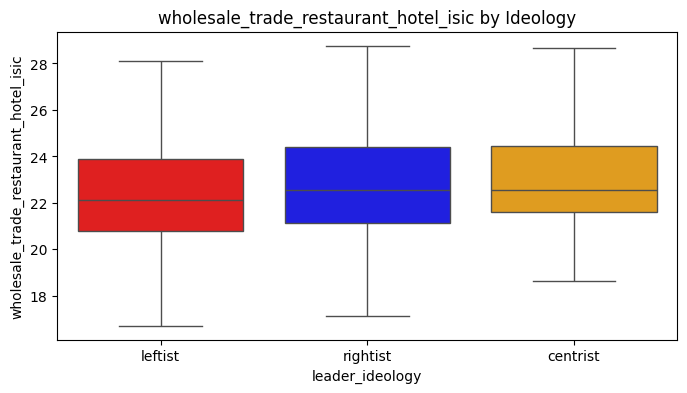

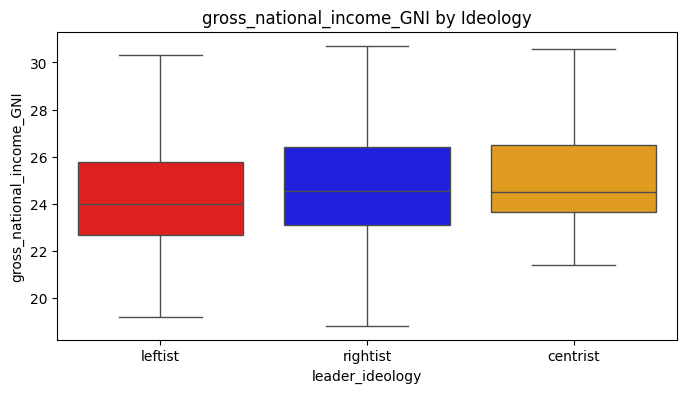

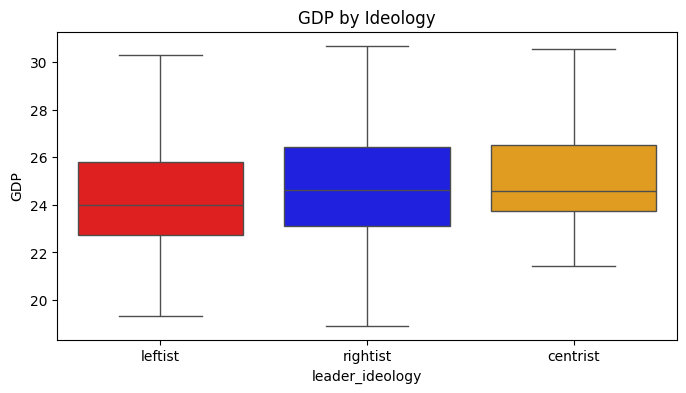

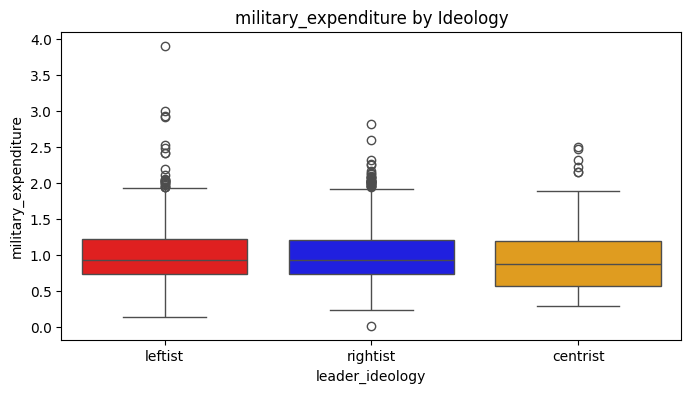

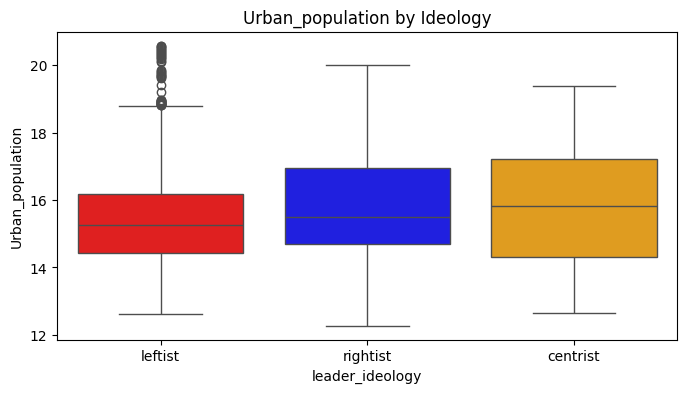

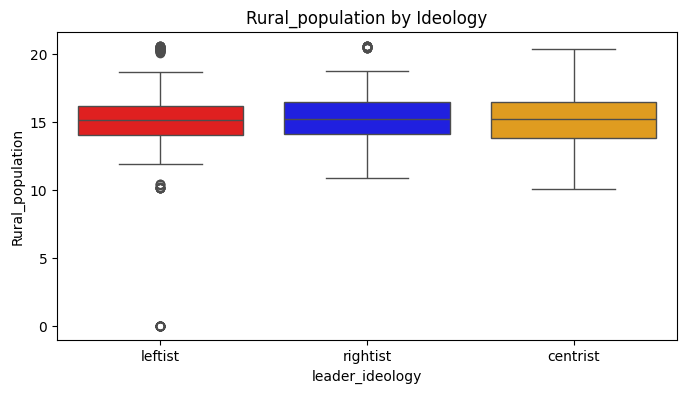

In [11]:

for feature in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_log, x='leader_ideology', y=feature,
                hue='leader_ideology',
    dodge=False,
    palette=['red', 'blue', 'orange'],
    legend=False)
    plt.title(f'{feature} by Ideology')
    plt.show()

To illustrate a bivariate relationship, we plotted military spending vs. income, colored by ideology:

Military expenditure (% of GDP) vs. per-capita GNI (log scale), colored by ruling ideology. We observe that high military spending (as %GDP) is more often associated with rightist governments (points in red) – many of those are lower-income countries with authoritarian right-wing regimes that maintain large militaries. Conversely, leftist governments (blue) are prevalent in the lower left quadrant (low-income, moderate military spend) and a few in upper middle (some richer socialist governments with moderate defence burdens). Centrist cases (green) cluster toward the right-middle: higher income, moderate military spend – think of stable democracies that neither spend excessively on military nor veer to ideological extremes. There are overlaps, of course, but this plot reinforces that military spending propensity is a potential distinguishing feature for ideology (we’ll test this in modelling). We did similar visuals for other variables (such as trade openness vs. ideology) and found less clear separation – e.g. trade levels did not differ consistently by ideology. NEED TO BE REVISED

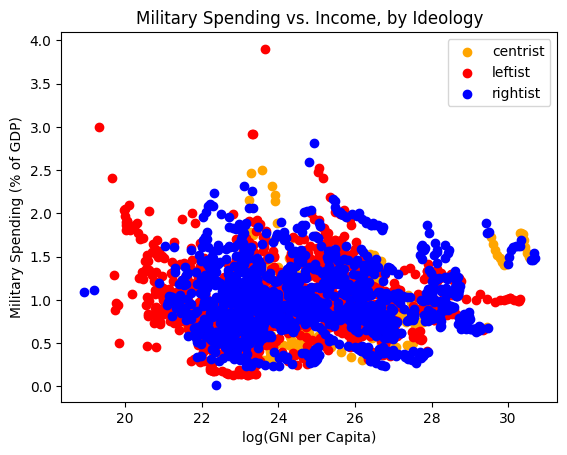

In [12]:
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}

plt.figure()
for i, ideology in enumerate(sorted(df_log['leader_ideology'].unique())):
    subset = df_log[df_log['leader_ideology'] == ideology]
    plt.scatter(
        subset['GDP'],
        subset['military_expenditure'],
        label=ideology,
        color=custom_palette[ideology]
    )
plt.xlabel("log(GNI per Capita)")
plt.ylabel("Military Spending (% of GDP)")
plt.title("Military Spending vs. Income, by Ideology")
plt.legend()
plt.show()

In [13]:
print(df_log['democracy'].unique())  # Check unique values
df_log['democracy'] = df_log['democracy'].replace('nan', np.nan)
print(df_log['democracy'].unique())  # Check unique values
print(df_log['leader_ideology'].unique())  # Check unique values

df_log = df_log.dropna(subset=['democracy'])
print(df_log['democracy'].unique())  # Check unique values


['no' 'yes' nan]
['no' 'yes' nan]
['leftist' 'rightist' 'centrist']
['no' 'yes']


We wanted to investigate further the trends related to our data and plotted military spending vs. income, colored by democracy:

Military expenditure (% of GDP) vs. per-capita GNI (log scale), colored by ruling democracy. We observe that high military spending (as %GDP) is more often associated with rightist governments (points in red) – many of those are lower-income countries with authoritarian right-wing regimes that maintain large militaries. Conversely, leftist governments (blue) are prevalent in the lower left quadrant (low-income, moderate military spend) and a few in upper middle (some richer socialist governments with moderate defence burdens). Centrist cases (green) cluster toward the right-middle: higher income, moderate military spend – think of stable democracies that neither spend excessively on military nor veer to ideological extremes. There are overlaps, of course, but this plot reinforces that military spending propensity is a potential distinguishing feature for ideology (we’ll test this in modelling). We did similar visuals for other variables (such as trade openness vs. ideology) and found less clear separation – e.g. trade levels did not differ consistently by ideology. NEED TO BE REVISED

Plotting: True with 1907 points.
Plotting: False with 1000 points.


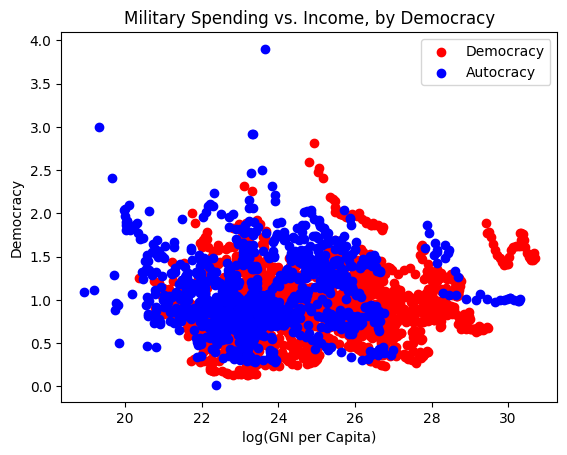

In [14]:


# Convert 'democracy' to lowercase strings and map 'yes'/'no' to True/False
df_log['democracy'] = df_log['democracy'].astype(str).str.lower().map({
    'yes': True,
    'no': False
})
custom_palette = {
    True: "red",
    False: "blue",
}

# Plotting
plt.figure()

for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    print(f"Plotting: {democracy} with {len(subset)} points.")  # Debugging output
    if len(subset) > 0:  # Only plot if there are points for that group
        plt.scatter(
            subset['GDP'],
            subset['military_expenditure'],
            label="Democracy" if democracy else "Autocracy",
            color=custom_palette[democracy]
        )

# Handle NaN values explicitly if they exist
nan_subset = df_log[df_log['democracy'].isna()]
if len(nan_subset) > 0:
    plt.scatter(
        nan_subset['GDP'],
        nan_subset['military_expenditure'],
        label="Unknown",  # Label for NaN values
        color="gray"  # Color for NaN values
    )

plt.xlabel("log(GNI per Capita)")
plt.ylabel("Democracy")
plt.title("Military Spending vs. Income, by Democracy")
plt.legend()
plt.show()

## 4. Hyphothesis

#### **Hypothesis 1:** We would expect higher the GDP/GNI leader ideologies tend to be more left. (classification hypothesis)

#### **Hypothesis 2:** We would expect higher income would result in lower military spending. (continuous hypothesis).

#### **Hypothesis 3:** We would expect more the development in the country more Urban population. We would expect Urban population is related to ideologies and economy  (count hypothesis).

#### **Hypothesis 4:** We would expect richer the country more probable to have democracy (binary hypothesis).



## 5. Building Predictive Models
### 5.1 Linear Models

*   log\_population (size of country),
    
*   log\_percap\_gni (economic development level),
    
*   GDP shares of government consumption, investment, agriculture, exports, and imports,
    
*   military_spending.


We'll select features and target variable to predict political ideology:

In [ ]:
# Encode target variable REVISION
#le = LabelEncoder()
#y_encoded = le.fit_transform(y)


In [ ]:
# Standardize features REVISION
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [15]:
#print(merged.columns)
df_log['leader_ideology'] = df_log['leader_ideology'].astype('category')
print(df_log['Urban_population'] )
df_log.describe()

0       13.995515
1       14.039069
2       14.046952
3       14.054697
4       14.062257
          ...    
2949    15.366326
2950    15.378926
2951    15.392931
2952    15.408597
2953    15.426184
Name: Urban_population, Length: 2907, dtype: float64


,Unnamed: 0,Year,IMF_based_exchange_rate,Population,Per_capita_GNI,agriculture_and_hunting_fishing_isic,Changes_in_inventories,construction_isic,Exports_of_goods_and_services,Gross_capital_formation,Imports_of_goods_and_services,mining_manifacturing_isic,transport_storage_communication_isic,wholesale_trade_restaurant_hotel_isic,gross_national_income_GNI,GDP,military_expenditure,Urban_population,Rural_population
count,2907.000000,2907.000000,2.907000e+03,2.907000e+03,2907.000000,2907.000000,2.907000e+03,2907.000000,2907.000000,2906.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2850.000000,2850.000000
mean,1475.927761,2005.417613,2.873732e+00,4.878521e+07,8.305029,21.884341,2.745778e+09,21.596581,23.456575,23.112808,23.611901,23.013356,22.053152,22.616685,24.598248,24.622855,0.978020,15.625173,15.100129
std,856.864902,8.776788,2.402169e+00,1.616460e+08,1.590030,1.760369,1.320264e+10,2.288962,2.205941,2.214052,2.017409,2.233749,2.256232,2.166506,2.146490,2.146125,0.398946,1.575860,2.321773
min,1.000000,1990.000000,2.990000e-08,3.653920e+05,4.543295,16.373707,-1.510000e+11,14.000905,17.266548,16.630189,17.922623,17.056585,16.297405,16.711084,18.838543,18.922174,0.016171,12.271977,0.000000
25%,730.500000,1998.000000,6.931472e-01,4.516300e+06,7.032624,20.746148,1.471190e+07,19.912635,21.898618,21.514193,22.113980,21.284411,20.381235,21.037944,22.982382,23.025552,0.718779,14.552580,14.054043
50%,1473.000000,2006.000000,2.009514e+00,1.045616e+07,8.252967,21.856542,2.915697e+08,21.451879,23.314762,22.930062,23.377696,22.872636,21.958474,22.390494,24.377617,24.415274,0.922722,15.390023,15.225273
75%,2220.500000,2013.000000,4.630512e+00,2.957408e+07,9.673414,23.004842,1.512241e+09,23.228185,25.135875,24.713918,25.124935,24.683323,23.704854,24.175114,26.189212,26.203905,1.208371,16.635494,16.298282
max,2954.000000,2020.000000,9.587626e+00,1.424930e+09,11.552050,27.796536,2.110000e+11,27.679811,28.631653,29.482621,28.772054,29.146148,28.441951,28.768854,30.712931,30.694412,3.902321,20.580331,20.631961


In [ ]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

Now, split our data:

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### 5.2 GLM Models





### 5.2.2 Poisson Model:

Here our response variable is Urban.population, and we keep the rest of the variables as predictors (except year and country).

In [22]:
# Train-Test Split
df_log['Urban_population'] = np.exp(df_log['Urban_population'])

print(df_log['Urban_population'] )

X_train, X_test, y_train, y_test = train_test_split(
    df_log.drop(columns='Urban_population'),  # predictors
    df_log['Urban_population'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)





0       1197223.0
1       1250519.0
2       1260415.0
3       1270215.0
4       1279854.0
          ...    
2949    4715312.0
2950    4775101.0
2951    4842448.0
2952    4918909.0
2953    5006180.0
Name: Urban_population, Length: 2907, dtype: float64


In [23]:
# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['Urban_population'] = y_train
print(train_data)




      Unnamed: 0                 Country  Year hog_ideology leader_ideology  \
1958        1959             New Zealand  2013     rightist        rightist   
163          164                 Austria  2015      leftist         leftist   
1989        1990               Nicaragua  2014      leftist         leftist   
252          253  Bosnia and Herzegovina  2018     rightist         leftist   
1873        1874                 Namibia  2018      leftist         leftist   
...          ...                     ...   ...          ...             ...   
1671        1672                    Mali  2017      leftist         leftist   
1098        1099                  Guinea  1993     rightist        rightist   
1134        1135                Honduras  2006      leftist         leftist   
1311        1312                  Israel  2014     rightist        rightist   
863          864                    Fiji  1993     rightist        rightist   

     match_hog_leader  democracy                   

There is overdispersion so we use quasipoisson model:

In [24]:
formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP'
qp_model = smf.glm(formula=formula, data=train_data, family=sm.families.Poisson()).fit(scale='dev')  # 'X2' enables quasi-poisson estimation
print(qp_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Urban_population   No. Observations:                 2283
Model:                            GLM   Df Residuals:                     2271
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                      7.3219e+05
Method:                          IRLS   Log-Likelihood:                -1135.5
Date:                Tue, 06 May 2025   Deviance:                   1.6628e+09
Time:                        21:00:54   Pearson chi2:                 1.62e+09
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Intercept (exp(-1.3196) = 0.2672): The baseline expected urban population when all predictors are at their reference levels (i.e., for a country with no democracy, no increase in GDP, etc.) is 0.2672 times the population level. This is a multiplicative factor, so if all predictors are at their baseline, the urban population is expected to be smaller.

Leader Ideology (rightist) (exp(-0.0248) = 0.9755): Countries with rightist leaders are expected to have about 2.45% lower urban populations compared to those with centrist or leftist leaders. This effect is statistically significant (P = 0.031).

Democracy (exp(0.0538) = 1.0553): Countries that are democracies (compared to non-democracies) are expected to have about 5.53% higher urban populations. This effect is significant (P = 0.000).

Per Capita GNI (exp(-0.7187) = 0.4875): For each unit increase in per capita GNI, the expected urban population decreases by about 51.25%. This is a significant negative relationship (P = 0.000), suggesting that wealthier countries tend to have lower urban population growth (potentially due to higher levels of urbanization already being achieved, or out-migration).

Construction Sector (exp(-0.0302) = 0.9701): For each unit increase in construction sector activity, the expected urban population decreases by about 2.99%. This effect is significant (P = 0.014), though it is quite small.

Imports of Goods and Services (exp(-0.1575) = 0.8546): A one-unit increase in imports of goods and services is associated with a 14.54% decrease in the expected urban population. This is a significant negative relationship (P = 0.000), suggesting that higher imports are associated with lower urban population growth.

Mining and Manufacturing Sector (exp(0.2445) = 1.2773): For each unit increase in mining and manufacturing sector activity, the expected urban population increases by about 27.73%. This effect is significant (P = 0.000).

Military Expenditure (exp(-0.0438) = 0.9575): For each unit increase in military expenditure, the expected urban population decreases by about 4.25%. This is a statistically significant negative effect (P = 0.000).

GDP (exp(0.9136) = 2.4940): For each unit increase in GDP, the expected urban population is expected to increase by about 149.40%. This is a strong and significant positive relationship (P = 0.000), indicating that wealthier nations tend to have higher urban populations.

Not Significant Variables:
Leader Ideology (leftist) (exp(-0.0071) = 0.9929): The effect of leftist leadership is very small and not statistically significant (P = 0.557), so this variable doesn’t have a substantial impact on urban population growth in this model.

Agriculture, Hunting, and Fishing (exp(-0.0144) = 0.9857): This variable also does not show a statistically significant effect (P = 0.130), so it does not seem to impact urban population growth significantly.

Transport, Storage, and Communication (exp(-0.0193) = 0.9808): The effect is small and not statistically significant (P = 0.281), so this factor doesn’t appear to have a meaningful relationship with urban population.

Summary: The urban population is expected to grow more significantly in wealthier countries (higher GDP) and countries with more manufacturing and mining activities. Democracies tend to have slightly larger urban populations, while countries with higher military spending and more imports tend to see a decrease in urban population growth.


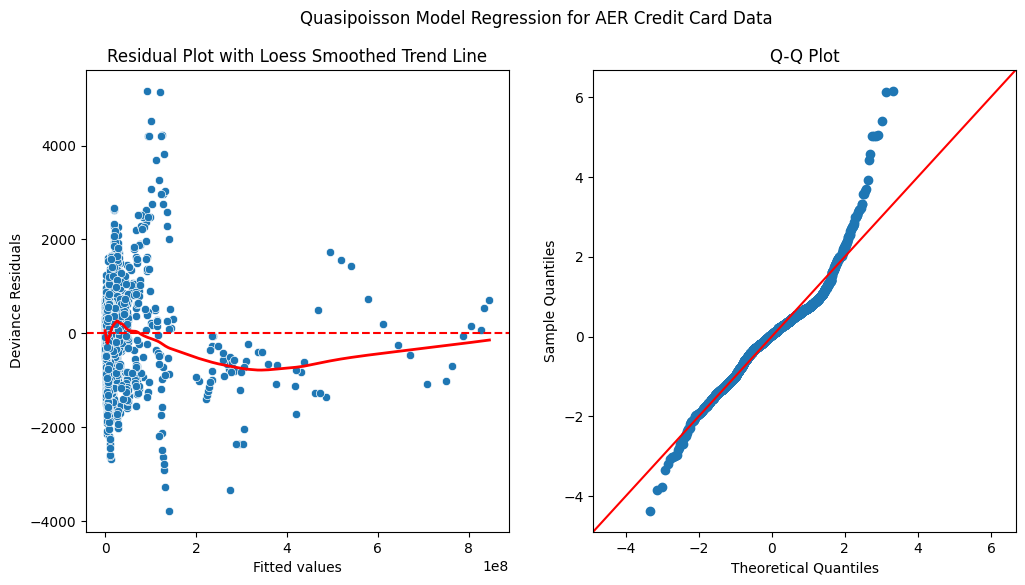

In [25]:


# Deviance residuals
deviance_residuals = qp_model.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Add an overall title
plt.suptitle('Quasipoisson Model Regression for AER Credit Card Data')

# Residual plot
sns.scatterplot(x=qp_model.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, qp_model.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

The residual plots show overdispersion and heteroscedasticity. Negative binomial might be a better approach. For the Negative binomial Model, alpha is calculated using MLE approach from quasipoisson model using R.

In [26]:

formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP '

model_nb = smf.glm(
    formula=formula,
    data=train_data,  # your cleaned dataframe
    family=sm.families.NegativeBinomial(alpha=2.43)
).fit()

result_nb = model_nb
print(result_nb.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       Urban_population   No. Observations:                 2283
Model:                            GLM   Df Residuals:                     2271
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39213.
Date:                Tue, 06 May 2025   Deviance:                       80.661
Time:                        21:05:31   Pearson chi2:                     70.7
No. Iterations:                    17   Pseudo R-squ. (CS):             0.6827
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------



Intercept (exp(-0.9069) = 0.4049): The baseline expected urban population. It is not statistically significant (P = 0.219).

Per Capita GNI (exp(-0.7498) = 0.4721): A 1-unit increase in Per Capita GNI is associated with a 52.79% decrease in the expected urban population. This is a significant negative relationship (P = 0.000), meaning that wealthier countries tend to have a lower urban population growth rate.

Mining and Manufacturing Sector (exp(0.1836) = 1.2012): A 1-unit increase in mining and manufacturing sector activity is associated with a 20.12% increase in the expected urban population. This is a significant positive relationship (P = 0.041), suggesting that countries with more activity in mining and manufacturing tend to have higher urban population growth.

Transport, Storage, and Communication (exp(0.2557) = 1.2912): A 1-unit increase in the transport, storage, and communication sector is associated with a 29.12% increase in the expected urban population. This is a significant positive relationship (P = 0.017), indicating that countries with more investment or activity in these sectors tend to experience higher urban population growth.

GDP (exp(0.6225) = 1.8647): A 1-unit increase in GDP is associated with a 86.47% increase in the expected urban population. This is a significant positive relationship (P = 0.002), meaning wealthier countries tend to have a larger urban population.

Leader Ideology (leftist) (exp(-0.0432) = 0.9574): The effect of leftist leaders on urban population growth is not statistically significant (P = 0.703). There is no substantial evidence to suggest that having a leftist leader has a meaningful impact on urban population growth.

Leader Ideology (rightist) (exp(-0.0535) = 0.9477): Similarly, the effect of rightist leaders on urban population growth is not statistically significant (P = 0.640). The effect is very small, and we do not observe any significant relationship here.

Democracy (exp(0.0948) = 1.0995): The effect of being a democracy on urban population growth is not statistically significant (P = 0.262), meaning democracies don’t show a strong effect on urban population compared to non-democracies.

Agriculture, Hunting, and Fishing Sector (exp(0.0002) = 1.0002): The effect of this sector is extremely small and not statistically significant (P = 0.998), meaning it has no meaningful impact on urban population growth.

Construction Sector (exp(-0.0017) = 0.9983): The effect of the construction sector is very small and not statistically significant (P = 0.982), indicating that this sector does not have a meaningful relationship with urban population growth in the model.

Imports of Goods and Services (exp(-0.1053) = 0.8994): This effect is not statistically significant (P = 0.222), so there is no clear evidence that an increase in imports is linked to urban population growth.

Military Expenditure (exp(0.1170) = 1.1238): While the coefficient is positive, the effect of military expenditure on urban population growth is not statistically significant (P = 0.189).

Summary: Wealthier countries (higher GDP and GNI) tend to experience slower urban population growth (especially with higher GNI), while countries with more activity in the mining, manufacturing, and transport sectors tend to see higher urban population growth.


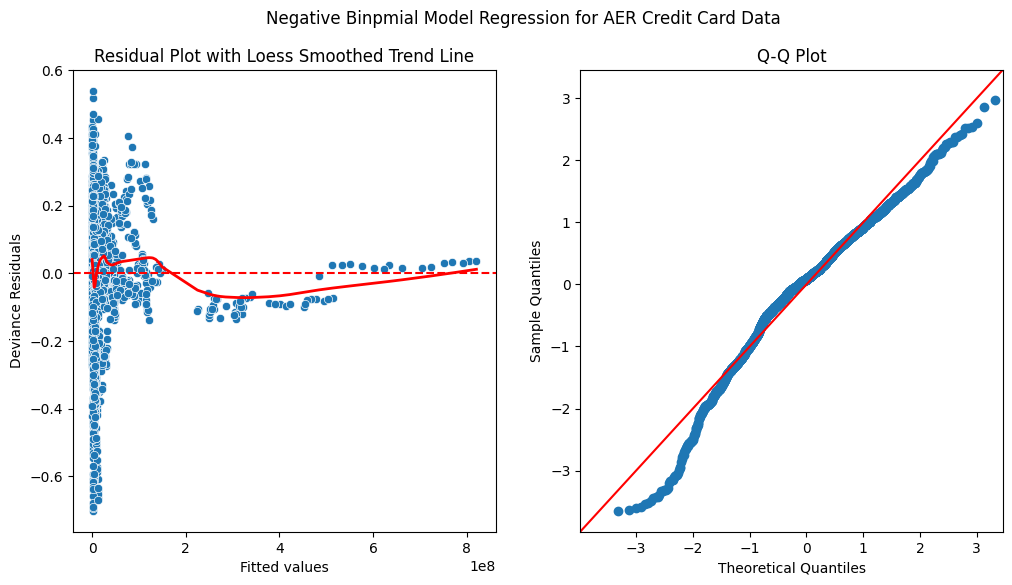

In [27]:


# Deviance residuals
deviance_residuals = model_nb.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Add an overall title
plt.suptitle('Negative Binpmial Model Regression for AER Credit Card Data')

# Residual plot
sns.scatterplot(x=model_nb.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, model_nb.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

Negative binomial model seems to be a good fit. QQplot is close to being flat and fitted vs residuals dispersed randomly around 0 (Fitted value scale is 1e8)

### 5.3 GAM Models


### 5.4 SVM Models

**Support Vector Machine (SVM):** We trained an SVM classifier with an RBF kernel to capture non-linear boundaries between ideological classes in the feature space. SVMs can handle multi-class via one-vs-one internally. We performed grid-search tuning of the regularization parameter on a validation split (to avoid overfitting, we then evaluated on test data).

In [32]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
print('SVM Accuracy:', accuracy_score(y_test, svm.predict(X_test)))

SVM Accuracy: 0.5447976878612717


### 5.4 Neural Networks

**Neural Network**:

## 6. Results
We'll use cross-validation to check our models:

## 7. Reflection on Generative AI
We use generative AI to help us write code, clarify methods, brainstorm, and interpret results. It was quick, but we faced several problems, especially when loading our data sets to draw conclusions. One of our data sets includes ideology information, and some generative AI tools are restricted and can't read such data. For example, **DeepSeek** didn't allow us to load the data set for conclusions. We tried **Perplexity AI**, but its conclusions were inaccurate. **Google Gemini** also failed because it couldn't load a CSV database.

So, we mainly used **OpenAI** and **ChatGPT**. With the free version, it is not possible to have full capacity for drawing conclusions from databases, but it helps clarify methods, brainstorm ideas, and understand correlations. Our hypothesis is complex, involving a social experiment comparing economic indicators and military investment to predict political ideologies. Drawing conclusions from such experiments is hard, but it was an interesting experience.


## 8. Conclusions
From our analysis, we've seen that economic indicators can help predict political ideologies, but not perfectly. Features like GDP, income levels, and military spending were important predictors. This analysis gives useful insights into how economics might influence politics globally.
